In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import collections

import sys
sys.path.append('../Tianwen')

import ccsds

plt.rcParams['figure.figsize'] = (7, 3.5)
plt.rcParams['figure.facecolor'] = 'w'

from construct import *

AOSFrame = Struct(
    'primary_header' / ccsds.AOSPrimaryHeader,
    'm_pdu_header' / ccsds.M_PDU_Header,
    'm_pdu_packet_zone' / ccsds.GreedyBytes
)

In [2]:
frames = np.fromfile('argomoon_frames.u8', 'uint8').reshape(-1, 5*223-2)
frames.shape

(14, 1113)

## AOS frames

Frames are AOS frames using spacecraft ID `0xdf` (assigned to [AGM in SANA registry](https://sanaregistry.org/r/spacecraftid/records/14867)). Virtual channels 2 and 63 (OID) are in use.

In [3]:
aos = [ccsds.AOSPrimaryHeader.parse(f) for f in frames]
scid = [a.spacecraft_id for a in aos]
vcid = np.array([a.virtual_channel_id for a in aos])
vcfc = np.array([a.virtual_channel_frame_count for a in aos])
aos[:5]

[Container(transfer_frame_version_number=1, spacecraft_id=223, virtual_channel_id=2, virtual_channel_frame_count=82, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=223, virtual_channel_id=2, virtual_channel_frame_count=83, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=223, virtual_channel_id=63, virtual_channel_frame_count=18, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=223, virtual_channel_id=2, virtual_channel_frame_count=84, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=223, virtual_channel_id=2, virtual_channel_frame_count=85, replay_flag=False, vc_frame_count_usage_flag=False, rs

In [4]:
collections.Counter(scid)

Counter({223: 14})

In [5]:
collections.Counter(vcid)

Counter({2: 9, 63: 5})

## VC 2

Virtual channel 2 carries data using the M_PDU protocol and Space Packets. Only APIDs 1 and 2047 are in use. APID 1 is used to send telemetry packets of different sizes. The packet structure depends on the packet size. Idle frames in APID 2047 are sent as needed to fill the remaining part of the AOS frame packet zone. The contents of APID 2047 idle packets are filled with `0xdc` bytes.

The packet sequence count for idle packets is always zero, but the telemetry packets have a valid sequence count.

In [6]:
frame_loss_vc2 = np.sum(np.diff(vcfc[vcid == 2]) - 1)
frame_loss_vc2

1

In [7]:
vcfc[vcid == 2]

array([82, 83, 84, 85, 86, 87, 88, 90, 91])

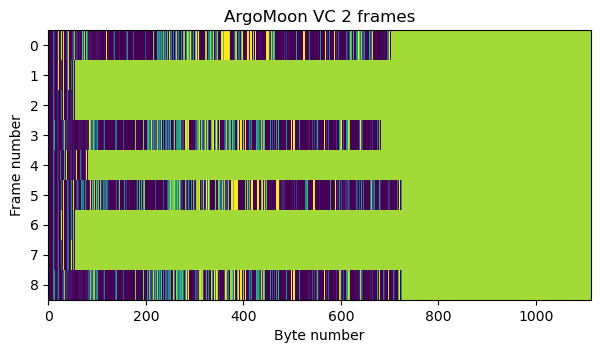

In [8]:
plt.imshow(frames[vcid == 2], aspect='auto', interpolation='none')
plt.title('ArgoMoon VC 2 frames')
plt.ylabel('Frame number')
plt.xlabel('Byte number');

In [9]:
frames_vc2 = [AOSFrame.parse(f) for f in frames[vcid == 2]]
packets = list(ccsds.extract_space_packets(frames_vc2, 223, 2))

/home/daniel/jupyter_notebooks/ArtemisI/../Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 223 VC 2] Broken stream. Last frame count 88, current frame count 90
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')


In [10]:
packet_headers = [ccsds.SpacePacketPrimaryHeader.parse(p) for p in packets]
packet_headers[:4]

[Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=1, sequence_flags=3, packet_sequence_count_or_name=12902, data_length=14),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=1, sequence_flags=3, packet_sequence_count_or_name=12903, data_length=662),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=2047, sequence_flags=3, packet_sequence_count_or_name=0, data_length=408),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=1, sequence_flags=3, packet_sequence_count_or_name=12904, data_length=14)]

In [11]:
apids = collections.Counter([p.APID for p in packet_headers])
apids

Counter({1: 20, 2047: 9})

In [12]:
by_apid = {apid : [p for h,p in zip(packet_headers, packets)
                   if h.APID == apid] for apid in apids}

In [13]:
all([a == 0xdc for p in by_apid[2047] for a in p[ccsds.SpacePacketPrimaryHeader.sizeof():]])

True

In [14]:
[ccsds.SpacePacketPrimaryHeader.parse(p) for p in by_apid[2047]]

[Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=2047, sequence_flags=3, packet_sequence_count_or_name=0, data_length=408),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=2047, sequence_flags=3, packet_sequence_count_or_name=0, data_length=1056),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=2047, sequence_flags=3, packet_sequence_count_or_name=0, data_length=1056),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=2047, sequence_flags=3, packet_sequence_count_or_name=0, data_length=429),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=2047, sequence_flags=3, packet_sequence_count_or_name=0, data_length=1029),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=2047, sequence_flags=3, packet_sequence_count_or_name=0, data_length=387),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=False, APID=2047, se

In [15]:
[ccsds.SpacePacketPrimaryHeader.parse(p) for p in by_apid[1]]

[Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=1, sequence_flags=3, packet_sequence_count_or_name=12902, data_length=14),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=1, sequence_flags=3, packet_sequence_count_or_name=12903, data_length=662),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=1, sequence_flags=3, packet_sequence_count_or_name=12904, data_length=14),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=1, sequence_flags=3, packet_sequence_count_or_name=12905, data_length=14),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=1, sequence_flags=3, packet_sequence_count_or_name=12906, data_length=14),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=1, sequence_flags=3, packet_sequence_count_or_name=12907, data_length=14),
 Container(ccsds_version=0, packet_type=0, secondary_header_flag=True, APID=1, sequence_flags

In [16]:
packet_lengths = collections.Counter([len(p) for p in by_apid[1]])
packet_lengths

Counter({21: 15, 669: 4, 27: 1})

In [17]:
by_len = {length: [p for p in packets if len(p) == length]
          for length in packet_lengths}

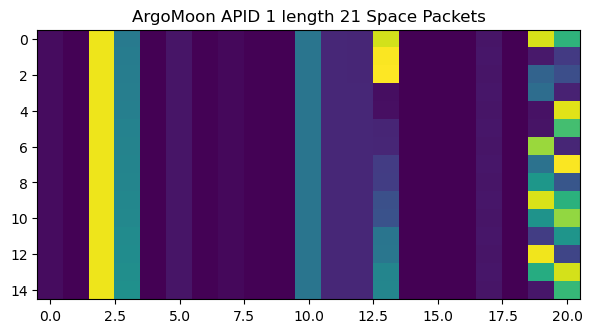

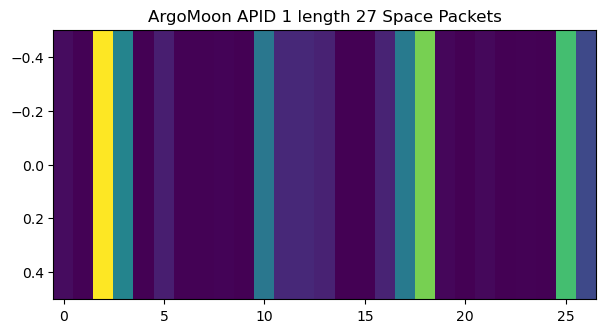

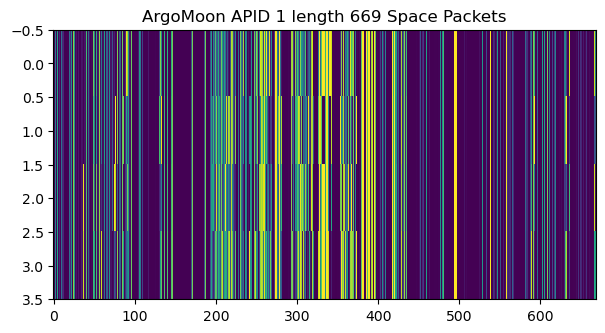

In [18]:
for length in sorted(by_len):
    plt.figure(figsize=(7, 3.5))
    plt.imshow(np.array([np.frombuffer(a, 'uint8') for a in by_len[length]]),
               aspect='auto', interpolation='None')
    plt.title(f'ArgoMoon APID 1 length {length} Space Packets')

In [19]:
[len(p) for p in by_apid[1]]

[21,
 669,
 21,
 21,
 21,
 21,
 669,
 27,
 21,
 21,
 21,
 21,
 669,
 21,
 21,
 21,
 21,
 669,
 21,
 21]

In [20]:
x = np.array([np.frombuffer(p[ccsds.SpacePacketPrimaryHeader.sizeof():][:12], 'uint8') for p in by_apid[1]])
x

array([[  1,   5,   1,   0,  96,  28,  27, 231,   0,   0,   0,  14],
       [  1,   3,  25,   0,  96,  28,  27, 238,   0,   0,   0,   1],
       [  1,   5,   1,   0,  96,  28,  27, 247,   0,   0,   0,  15],
       [  1,   5,   1,   0,  96,  28,  27, 248,   0,   0,   0,  14],
       [  1,   5,   1,   0,  96,  28,  28,   9,   0,   0,   0,  15],
       [  1,   5,   1,   0,  96,  28,  28,  10,   0,   0,   0,  14],
       [  1,   3,  25,   0,  96,  28,  28,  14,   0,   0,   0,   1],
       [  1,   1,   2,   0,  96,  28,  28,  23,   0,   0,  24, 100],
       [  1,   5,   1,   0,  96,  28,  28,  26,   0,   0,   0,  15],
       [  1,   5,   1,   0,  96,  28,  28,  27,   0,   0,   0,  14],
       [  1,   5,   1,   0,  96,  28,  28,  44,   0,   0,   0,  15],
       [  1,   5,   1,   0,  96,  28,  28,  45,   0,   0,   0,  14],
       [  1,   3,  25,   0,  96,  28,  28,  46,   0,   0,   0,   1],
       [  1,   5,   1,   0,  96,  28,  28,  61,   0,   0,   0,  15],
       [  1,   5,   1,   0,  96,  

## VC 63

Idle frames in VC 63 contain `0x07fe` after the AOS primary header. This is most likely an M_PDU header indicating that the packet zone contains only idle data. The packet zone is filled with `0xdc`.

In [21]:
frame_loss_vc63 = np.sum(np.diff(vcfc[vcid == 63]) - 1)
frame_loss_vc63

1

In [22]:
vcfc[vcid == 63]

array([18, 19, 20, 21, 23])

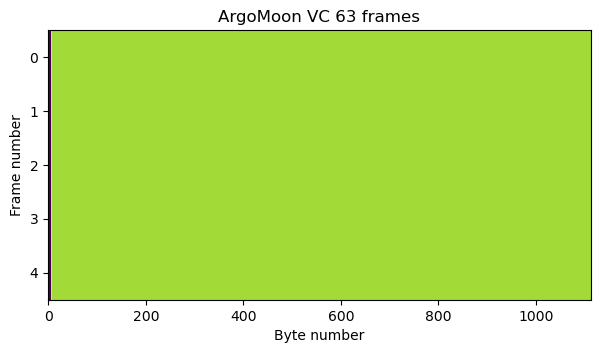

In [23]:
plt.imshow(frames[vcid == 63], aspect='auto', interpolation='none')
plt.title('ArgoMoon VC 63 frames')
plt.ylabel('Frame number')
plt.xlabel('Byte number');

In [24]:
np.all(frames[vcid == 63][:, 6:] == frames[vcid == 63][0, 6:])

True

In [25]:
ccsds.M_PDU_Header.parse(frames[vcid == 63][0, 6:])

Container(rsv_spare=0, first_header_pointer=2046)

In [26]:
np.all(frames[vcid == 63][0, 8:] == 0xdc)

True